# Experiment of adversarial-camera-stickers

Consider digital attacks only.

## Data preparation and preprocessings

In [1]:
from skimage import io
img_array = io.imread("../image/1200px-STOP_sign.jpg")

In [2]:
img_array.shape

(1296, 1200, 3)

In [3]:
import matplotlib.pyplot as plt

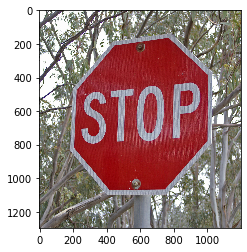

In [4]:
plt.figure()
plt.imshow(img_array)
plt.show()

In [5]:
from torchvision import transforms
import PIL
import copy


composed = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


def plot_img_from_normalized_img(img_array, is_normalized=True):
    img_to_be_plotted = copy.deepcopy(img_array)
    assert len(img_array.shape) == 3
    if img_to_be_plotted.shape[0] == 3:
        img_to_be_plotted = img_to_be_plotted.transpose(1, 2, 0)
    if is_normalized:
        for idx, (m, v) in enumerate(zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
            img_to_be_plotted[:, :, idx] = (img_to_be_plotted[:, :, idx] * v) + m
    plt.figure()
    plt.imshow(img_to_be_plotted)
    plt.show()

In [6]:
transformed_img = composed(PIL.Image.fromarray(img_array))

In [7]:
transformed_img.shape

torch.Size([3, 256, 256])

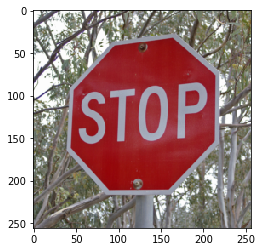

In [8]:
plot_img_from_normalized_img(transformed_img.detach().numpy())

In [9]:
import json

with open("../imagenet_class_index.json") as json_file:
    class_idx = json.load(json_file)

idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [10]:
idx2label[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

## Model definition

In [11]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [12]:
class ImageDot(nn.Module):
    def __init__(self):
        super(ImageDot, self).__init__()
        self.means = [0.485, 0.456, 0.406]
        self.stds = [0.229, 0.224, 0.225]
        self.alpha = 0.5
        self.radius = 25.0
        self.beta = 2.0
        self.center = nn.Parameter(torch.tensor([
            [0.25, 0.25], [0.25, 0.5], [0.25, 0.75],
            [0.5, 0.25], [0.5, 0.5], [0.5, 0.75],
            [0.75, 0.25], [0.75, 0.5], [0.75, 0.75]]),
            requires_grad=True)
        self.color = nn.Parameter(torch.tensor([
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
            requires_grad=True)
    
    def forward(self, x):
        _, _, height, width = x.shape
        blended = x
        for idx in range(self.center.shape[0]):
            mask = self._create_circle_mask(height, width, self.center[idx] * 255.0, self.beta)
            normalized_color = self._normalize_color(self.color[idx], self.means, self.stds)
            blended = self._create_blended_img(blended, mask, normalized_color)
        return blended
 
    def _normalize_color(self, color, means, stds):
        return list(map(lambda x, m, s: (x - m) / s, color, means, stds))

    def _create_circle_mask(self, height, width, center, beta):
        hv, wv = torch.meshgrid([torch.arange(0, height), torch.arange(0, width)])
        hv, wv = hv.type(torch.FloatTensor), wv.type(torch.FloatTensor)
        d = ((hv - center[0]) ** 2 + (wv - center[1]) ** 2) / self.radius ** 2
        return torch.exp(- d ** beta + 1e-10)

    def _create_blended_img(self, base, mask, color):
        alpha_tile = mask.expand(3, mask.shape[0], mask.shape[1])
        color_tile = torch.zeros_like(base)
        for c in range(3):
            color_tile[:, c, :, :] = color[c]
        return (1. - alpha_tile) * base + self.alpha * alpha_tile * color_tile


class AttackModel(nn.Module):
    def __init__(self):
        super(AttackModel, self).__init__()
        self.image_dot = ImageDot()
        self.base_model = models.resnet50(pretrained=True).eval()     
        self._freeze_pretrained_model()

    def _freeze_pretrained_model(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.image_dot(x)
        return self.base_model(x)

## Model training

In [13]:
torch.manual_seed(0)

In [14]:
model = AttackModel()

Check predictions before attacks.  
The image is correctly predicted as `street_sign`.

In [15]:
pred = model.base_model(transformed_img.unsqueeze(0))
pred = np.squeeze(pred.detach().numpy())
for elem in np.argsort(pred)[-10:]:
    print(f"class: {idx2label[elem]}, idx: {elem}, logit: {pred[elem]:.4f}")

class: harvester, idx: 595, logit: 6.0803
class: boathouse, idx: 449, logit: 6.5917
class: scoreboard, idx: 781, logit: 6.7801
class: chainlink_fence, idx: 489, logit: 7.7015
class: birdhouse, idx: 448, logit: 7.9526
class: mailbox, idx: 637, logit: 7.9899
class: barn, idx: 425, logit: 7.9944
class: traffic_light, idx: 920, logit: 8.5474
class: water_tower, idx: 900, logit: 9.2191
class: street_sign, idx: 919, logit: 13.6607


Check the initial masks.

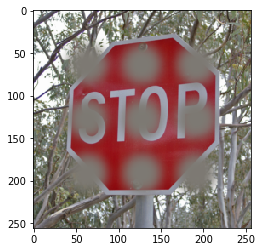

In [16]:
dotted_img = model.image_dot(transformed_img.unsqueeze(0))
plot_img_from_normalized_img(dotted_img.squeeze().detach().numpy())

In [17]:
# 919: street_sign
# 595: harvester

def compute_loss(pred, true_label_idx=919, target_label_idx=595):
    true_label_contrib = F.nll_loss(pred, torch.tensor([true_label_idx]))
    target_label_contrib = F.nll_loss(pred, torch.tensor([target_label_idx]))
#     return torch.mean(- true_label_contrib)  # non-targeted attack
    return torch.mean(- true_label_contrib + target_label_contrib)  # targeted attack

In [18]:
# lr = 0.005
lr = 0.008
loss_function = nn.NLLLoss()

for epoch in range(200):
    if (epoch + 1) % 50 == 0:
        lr /= 2.0
    model.zero_grad()
    pred = model(transformed_img.unsqueeze(0))
    loss = compute_loss(pred)
    loss.backward(retain_graph=True)

    print(f"epoch: {epoch + 1}, loss: {loss.data:.4f}")

    for param in model.parameters():
        if param.requires_grad == True:
            param.data = torch.clamp(param.data - param.grad.data * lr, min=0.0, max=1.0)

epoch: 1, loss: 5.7363
epoch: 2, loss: 7.0670
epoch: 3, loss: 7.8236
epoch: 4, loss: 6.5193
epoch: 5, loss: 5.3812
epoch: 6, loss: 5.9340
epoch: 7, loss: 4.6816
epoch: 8, loss: 6.3233
epoch: 9, loss: 6.0489
epoch: 10, loss: 5.2337
epoch: 11, loss: 5.3150
epoch: 12, loss: 6.5853
epoch: 13, loss: 6.0773
epoch: 14, loss: 6.7113
epoch: 15, loss: 4.7825
epoch: 16, loss: 6.0057
epoch: 17, loss: 5.9905
epoch: 18, loss: 8.0073
epoch: 19, loss: 7.9798
epoch: 20, loss: 5.3601
epoch: 21, loss: 3.5391
epoch: 22, loss: 6.3735
epoch: 23, loss: 5.9733
epoch: 24, loss: 7.1977
epoch: 25, loss: 4.9841
epoch: 26, loss: 4.6693
epoch: 27, loss: 4.5180
epoch: 28, loss: 6.6276
epoch: 29, loss: 5.5098
epoch: 30, loss: 4.7832
epoch: 31, loss: 6.8387
epoch: 32, loss: 4.8358
epoch: 33, loss: 5.3107
epoch: 34, loss: 6.5734
epoch: 35, loss: 6.4443
epoch: 36, loss: 3.7938
epoch: 37, loss: 5.9711
epoch: 38, loss: 7.0563
epoch: 39, loss: 6.4326
epoch: 40, loss: 5.4976
epoch: 41, loss: 6.0281
epoch: 42, loss: 4.7278
e

In [19]:
for elem in model.parameters():
    if elem.requires_grad == True:
        print(elem)

Parameter containing:
tensor([[0.2654, 0.4921],
        [0.3639, 0.0630],
        [0.9693, 0.0063],
        [0.0045, 0.1802],
        [0.1886, 0.8087],
        [0.2193, 0.6388],
        [0.9417, 0.6045],
        [0.6930, 0.8539],
        [0.4269, 0.8651]], requires_grad=True)
Parameter containing:
tensor([[0.7016, 0.2729, 0.7504],
        [0.6815, 0.3075, 0.7450],
        [0.8149, 0.3431, 0.4189],
        [0.7047, 0.2529, 0.5498],
        [0.6429, 0.2829, 0.6452],
        [0.4339, 0.3909, 0.6170],
        [0.9113, 0.3560, 0.3849],
        [1.0000, 0.2243, 0.3289],
        [0.4313, 0.9169, 0.2219]], requires_grad=True)


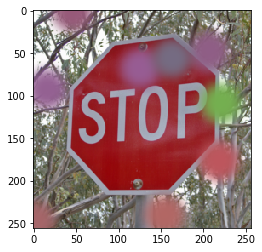

In [20]:
doted_img = model.image_dot(transformed_img.unsqueeze(0))
plot_img_from_normalized_img(doted_img.squeeze().detach().numpy())

In [21]:
pred = model(transformed_img.unsqueeze(0))
pred = np.squeeze(pred.detach().numpy())
for elem in np.argsort(pred)[-10:]:
    print(f"class: {idx2label[elem]}, idx: {elem}, logit: {pred[elem]:.4f}")

class: paddlewheel, idx: 694, logit: 7.4071
class: water_tower, idx: 900, logit: 7.9984
class: street_sign, idx: 919, logit: 8.0015
class: boathouse, idx: 449, logit: 8.0996
class: thresher, idx: 856, logit: 8.1095
class: tractor, idx: 866, logit: 8.2329
class: birdhouse, idx: 448, logit: 8.9090
class: mailbox, idx: 637, logit: 9.7481
class: barn, idx: 425, logit: 10.5123
class: harvester, idx: 595, logit: 10.5581


non-targeted attack expectation:

```
class: fire_engine, idx: 555, logit: 5.3237
class: Angora, idx: 332, logit: 5.3764
class: hummingbird, idx: 94, logit: 5.5466
class: birdhouse, idx: 448, logit: 5.8852
class: chainlink_fence, idx: 489, logit: 6.1855
class: street_sign, idx: 919, logit: 6.3579
class: mailbox, idx: 637, logit: 6.6507
class: water_tower, idx: 900, logit: 7.3716
class: barn, idx: 425, logit: 7.4384
class: feather_boa, idx: 552, logit: 9.2908
```

targeted attack expectation:

```
class: paddlewheel, idx: 694, logit: 7.4071
class: water_tower, idx: 900, logit: 7.9984
class: street_sign, idx: 919, logit: 8.0015
class: boathouse, idx: 449, logit: 8.0996
class: thresher, idx: 856, logit: 8.1095
class: tractor, idx: 866, logit: 8.2329
class: birdhouse, idx: 448, logit: 8.9090
class: mailbox, idx: 637, logit: 9.7481
class: barn, idx: 425, logit: 10.5123
class: harvester, idx: 595, logit: 10.5581
```